In [19]:
from io import StringIO

import matplotlib.pyplot as plt
from scipy.io import arff
import seaborn as sns
from loguru import logger
import yaml

from datetime import datetime
import polars as pl
import pandas as pd
import numpy as np
import os

# MODEL
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import (
    LabelEncoder, 
    StandardScaler,
    label_binarize
)
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_recall_fscore_support,
    balanced_accuracy_score,
    roc_auc_score,
    roc_curve
)

# Save variables for model
import joblib


# PERSONAL FUNCTIONS
from utils import *
from functions.windows import create_feature_windows # creación de ventanas e ingenieria de características

**Nota:** Se determinó que el formato 'Timestamp' está en nanosegundos. Aunque se exploró con las otras métricas (microsegundos y milisegundos), ninguna coincidia con la frecuencia de muestreo de 20Hz se aproxima a 0.05 segundos.

In [20]:
# Cargar datos
path_base = r"F:\UPC\Tesis\HARbit-Model\src\data\wisdm-dataset\raw\watch"
sensor_data = load_sensors_separately(path_base)
df_gyro = sensor_data['gyro']
df_gyro = df_gyro.rename({'X': 'X_gyro', 'Y': 'Y_gyro', 'Z': 'Z_gyro'})

df_accel = sensor_data['accel']
df_accel = df_accel.rename({'X': 'X_accel', 'Y': 'Y_accel', 'Z': 'Z_accel'})

print(f"Giroscopio: {len(df_gyro)} muestras")
print(f"Acelerómetro: {len(df_accel)} muestras")

2025-09-18 23:06:49.631 | INFO     | utils.data_loading:load_sensors_separately:64 - Cargando datos de gyro...
2025-09-18 23:06:54.438 | INFO     | utils.data_loading:load_sensors_separately:64 - Cargando datos de accel...


Giroscopio: 3440341 muestras
Acelerómetro: 3777045 muestras


In [28]:
df_all_sensors = df_gyro.join(df_accel, on = ['Subject-id', 'Timestamp', 'Activity Label'], how = "inner")

In [29]:
df_gyro_inner = df_all_sensors.select(
    pl.col('Subject-id'),
    pl.col('Activity Label'),
    pl.col('Timestamp'),
    pl.col('X_gyro').alias('X'),
    pl.col('Y_gyro').alias('Y'),
    pl.col('Z_gyro').alias('Z')
)

In [30]:
df_accel_inner = df_all_sensors.select(
    pl.col('Subject-id'),
    pl.col('Activity Label'),
    pl.col('Timestamp'),
    pl.col('X_accel').alias('X'),
    pl.col('Y_accel').alias('Y'),
    pl.col('Z_accel').alias('Z')
)

In [31]:
with open(r'F:\UPC\Tesis\HARbit-Model\src\config\activities.yaml', 'r') as file:
    config = yaml.safe_load(file)['config']

In [36]:
df_gyro_inner = df_gyro_inner.to_pandas()

In [37]:
df_accel_inner = df_accel_inner.to_pandas()

In [38]:
activities_ = config['labels'] 
cluster_ = config['clusters']

df_gyro_inner['Activity Label'] = df_gyro_inner['Activity Label'].apply(lambda x: activities_[x])
df_accel_inner['Activity Label'] = df_accel_inner['Activity Label'].apply(lambda x: activities_[x])

for activity in cluster_.keys():
    for act in cluster_[activity]:
        df_gyro_inner.loc[df_gyro_inner['Activity Label'] == act, 'Activity Label'] = activity
        df_accel_inner.loc[df_accel_inner['Activity Label'] == act, 'Activity Label'] = activity

In [44]:
df_gyro_inner_t = df_gyro_inner[df_gyro_inner['Activity Label'] == 'Type']
df_accel_inner_t = df_accel_inner[df_accel_inner['Activity Label'] == 'Type']

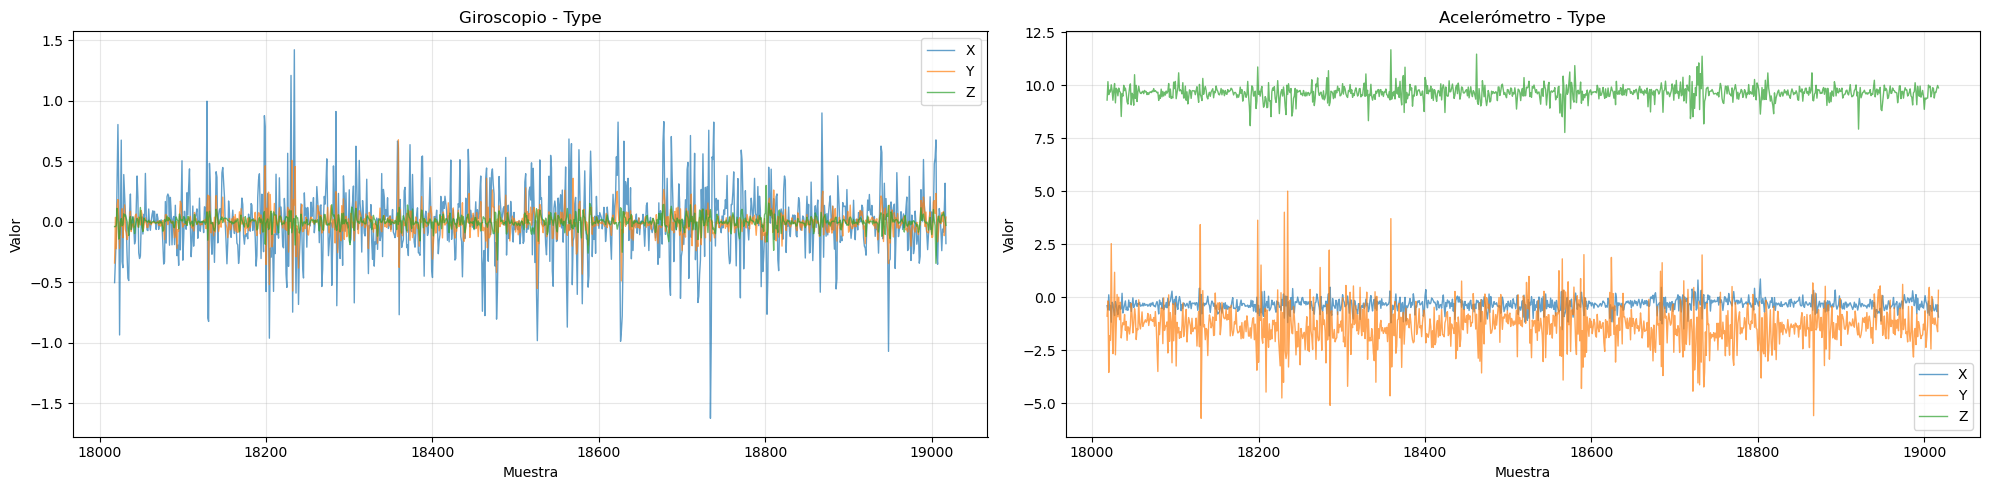

In [46]:
def plot_axes_by_activity(df_gyro, df_accel, max_samples_per_activity=1000, figsize=(15, 12)):
    """
    Visualiza los ejes X, Y, Z del giroscopio y acelerómetro por cada actividad
    """
    # Obtener actividades únicas
    activities = df_gyro['Activity Label'].unique().tolist()
    n_activities = len(activities)
    
    # Crear subplots
    fig, axes = plt.subplots(n_activities, 2, figsize=figsize)
    if n_activities == 1:
        axes = axes.reshape(1, -1)
    
    for i, activity in enumerate(activities):
        # Filtrar datos por actividad
        gyro_activity = df_gyro[df_gyro['Activity Label'] == activity]
        accel_activity =  df_accel[df_accel['Activity Label'] == activity]
        
        # Limitar muestras para mejor visualización
        if len(gyro_activity) > max_samples_per_activity:
            gyro_activity = gyro_activity.head(max_samples_per_activity)
        if len(accel_activity) > max_samples_per_activity:
            accel_activity = accel_activity.head(max_samples_per_activity)
        
        # Convertir a pandas para plotting
        gyro_pd = gyro_activity.copy()
        accel_pd = accel_activity.copy()
        
        # Plot Giroscopio
        axes[i, 0].plot(gyro_pd['X'], label='X', alpha=0.7, linewidth=1)
        axes[i, 0].plot(gyro_pd['Y'], label='Y', alpha=0.7, linewidth=1)
        axes[i, 0].plot(gyro_pd['Z'], label='Z', alpha=0.7, linewidth=1)
        axes[i, 0].set_title(f'Giroscopio - {activity}')
        axes[i, 0].set_ylabel('Valor')
        axes[i, 0].legend()
        axes[i, 0].grid(True, alpha=0.3)
        
        # Plot Acelerómetro
        axes[i, 1].plot(accel_pd['X'], label='X', alpha=0.7, linewidth=1)
        axes[i, 1].plot(accel_pd['Y'], label='Y', alpha=0.7, linewidth=1)
        axes[i, 1].plot(accel_pd['Z'], label='Z', alpha=0.7, linewidth=1)
        axes[i, 1].set_title(f'Acelerómetro - {activity}')
        axes[i, 1].set_ylabel('Valor')
        axes[i, 1].legend()
        axes[i, 1].grid(True, alpha=0.3)
        
        # Añadir xlabel solo en la última fila
        if i == n_activities - 1:
            axes[i, 0].set_xlabel('Muestra')
            axes[i, 1].set_xlabel('Muestra')
    
    plt.tight_layout()
    plt.show()

# Ejecutar visualización
plot_axes_by_activity(df_gyro_inner_t, df_accel_inner_t, figsize = (20, 5))

In [7]:
# Extraer características con diferentes sobrelapamientos
print("Extrayendo características...")

features_50_accel = create_feature_windows(df_accel_inner, window_seconds=5, overlap_percent=50)
features_50_gyro = create_feature_windows(df_gyro_inner, window_seconds=5, overlap_percent=50)

Extrayendo características...


In [ ]:
features_50_accel.to_csv(r'./data/preprocess/accel_50%-overlaping_5s-windows.csv', index = False)
features_50_gyro.to_csv(r'./data/preprocess/gyro_50%-overlaping_5s-windows.csv', index = False)

In [2]:
features_50_accel = pd.read_csv(r'./data/preprocess/accel_50%-overlaping_5s-windows.csv')
features_50_gyro = pd.read_csv(r'./data/preprocess/gyro_50%-overlaping_5s-windows.csv')

In [3]:
features_combined = pd.merge(
    features_50_gyro,
    features_50_accel, 
    on=['Subject-id', 'Activity Label', 'window_start', 'window_end', 'sample_count'], 
    how="inner"
)

In [ ]:
with open(r'F:\UPC\Tesis\HARbit-Model\src\config\activities.yaml', 'r') as file:
    config = yaml.safe_load(file)['config']

In [5]:
activities_ = config['labels'] 
cluster_ = config['clusters']

In [ ]:
features_combined['Activity Label'] = features_combined['Activity Label'].apply(lambda x: activities_[x])

In [7]:
for activity in cluster_.keys():
    for act in cluster_[activity]:
        features_combined.loc[features_combined['Activity Label'] == act, 'Activity Label'] = activity

In [8]:
ls_columns_gyro = [col for col in features_combined.columns if col.endswith('_x')]
ls_columns_accel = [col for col in features_combined.columns if col.endswith('_y')]

In [9]:
features_combined_without_sensor = features_combined.drop(columns = ls_columns_gyro)

In [10]:
data_train, data_test, data_val = split_by_user(features_combined, num_user_test = 3, num_user_val = 3)

In [11]:
X_train, y_train, subjects, label_encoder = prepare_features_for_cnn_lstm_sequences(
    data_train,
    group_size = 8, 
    step_size = 1
)

num_classes = len(label_encoder.classes_)

✅ Secuencias creadas: (50621, 8, 136)
  Num features: 136
  Clases: ['Eat' 'Others' 'Sit' 'Stand' 'Type' 'Walk' 'Workouts' 'Write']


In [12]:
X_test, y_test, _, _ = prepare_features_for_cnn_lstm_sequences(
    data_test,
    group_size = 8, 
    step_size = 1
)

✅ Secuencias creadas: (3652, 8, 136)
  Num features: 136
  Clases: ['Eat' 'Others' 'Sit' 'Stand' 'Type' 'Walk' 'Workouts' 'Write']


In [13]:
X_val, y_val, subjects, label_encoder = prepare_features_for_cnn_lstm_sequences(
    data_train,
    group_size = 8,
    step_size = 1
)

✅ Secuencias creadas: (50621, 8, 136)
  Num features: 136
  Clases: ['Eat' 'Others' 'Sit' 'Stand' 'Type' 'Walk' 'Workouts' 'Write']


In [14]:
from models.main import *
input_shape = (X_train.shape[1], X_train.shape[2])


model = create_cnn_lstm_model(input_shape = input_shape, num_classes = num_classes)

c:\Users\HP\miniconda3\envs\forecasting\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Entrenar modelo
print("Entrenando modelo CNN-LSTM...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Entrenando modelo CNN-LSTM...
Epoch 1/100
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.8791 - loss: 0.3821 - val_accuracy: 0.9509 - val_loss: 0.1508 - learning_rate: 0.0010
Epoch 2/100
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - accuracy: 0.9353 - loss: 0.2119 - val_accuracy: 0.9632 - val_loss: 0.1193 - learning_rate: 0.0010
Epoch 3/100
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.9483 - loss: 0.1715 - val_accuracy: 0.9632 - val_loss: 0.1106 - learning_rate: 0.0010
Epoch 4/100
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.9576 - loss: 0.1405 - val_accuracy: 0.9798 - val_loss: 0.0611 - learning_rate: 0.0010
Epoch 5/100
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 44s 26ms/step - accuracy: 0.9648 - loss: 0.1179 - val_accuracy: 0.9804 - val_loss: 0.0632 - learning_rate: 0.0010
Epoch 6/100
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 39s 24ms/step - accuracy: 0.9674 - loss: 0.1057 - val_accuracy: 0.9779 - val_loss: 0.0787 - learning_rate: 0.0010
Epoch 7/100
1582/1582 ━━━━━━

Evaluando modelo...
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step

Pérdida en test: 0.2473
Precisión en test: 0.9743

REPORTE DE CLASIFICACIÓN
              precision    recall  f1-score   support

         Eat     0.9598    0.9875    0.9734      1039
      Others     0.9984    1.0000    0.9992       616
         Sit     0.9005    0.9526    0.9258       190
       Stand     0.9632    0.8177    0.8845       192
        Type     0.9010    0.9529    0.9262       191
        Walk     1.0000    1.0000    1.0000       617
    Workouts     1.0000    1.0000    1.0000       616
       Write     0.9760    0.8534    0.9106       191

    accuracy                         0.9743      3652
   macro avg     0.9624    0.9455    0.9525      3652
weighted avg     0.9747    0.9743    0.9738      3652



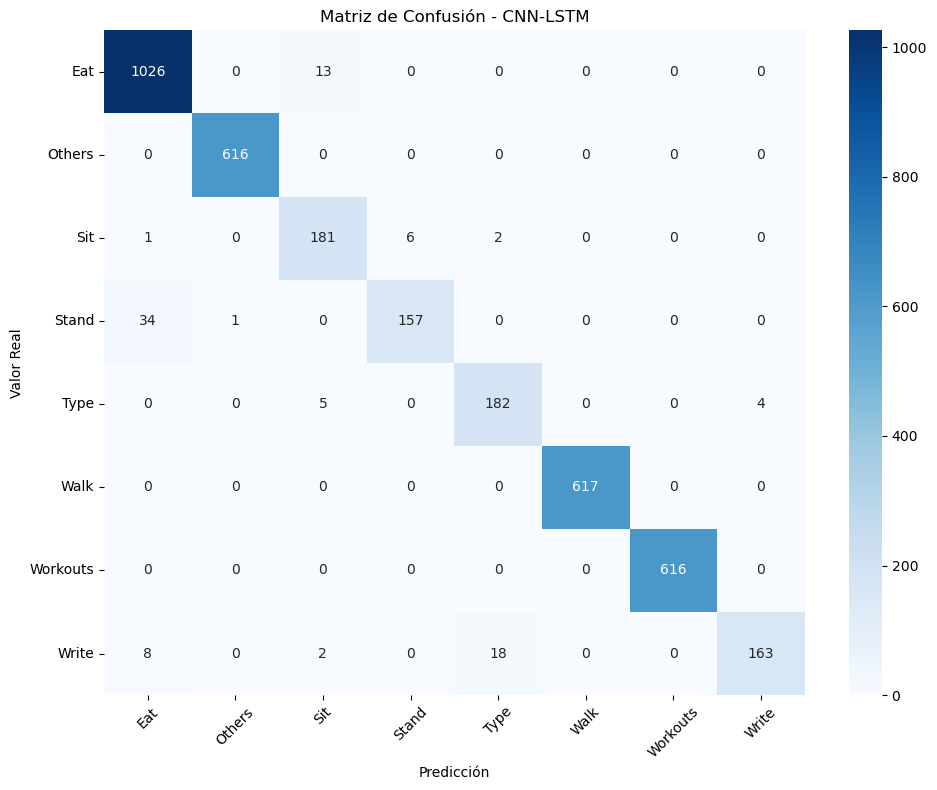

In [16]:
print("Evaluando modelo...")

# Predicciones
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Métricas básicas
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nPérdida en test: {test_loss:.4f}")
print(f"Precisión en test: {test_accuracy:.4f}")

# Reporte de clasificación detallado
print("\n" + "="*50)
print("REPORTE DE CLASIFICACIÓN")
print("="*50)
print(classification_report(
    y_test, 
    y_pred_classes, 
    target_names=label_encoder.classes_,
    digits=4
))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Matriz de Confusión - CNN-LSTM')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [17]:
model.save(r'F:\UPC\Tesis\HARbit-Model\src\models\cnn-lstm_wisdm_har_model_97_cluster_user.h5')
joblib.dump(label_encoder, r'F:\UPC\Tesis\HARbit-Model\src\models\meta\le_wisdm_cnn_lstm_97_cluster_user.joblib')

['F:\\UPC\\Tesis\\HARbit-Model\\src\\models\\meta\\le_wisdm_cnn_lstm_97_cluster_user.joblib']

In [46]:
# ==============================================
# ANÁLISIS COMPLETO DE OVERFITTING PARA SECUENCIAS
# ==============================================
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

def analyze_overfitting(model, X_train, y_train, X_test, y_test, label_encoder):
    """
    Análisis completo de overfitting comparando train vs test
    para entradas con forma (N, timesteps, features)
    """
    print("🔍 ANÁLISIS DE OVERFITTING")
    print("="*60)
    
    # Evaluar en datos de entrenamiento
    print("📊 Evaluando en datos de ENTRENAMIENTO...")
    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    train_pred = model.predict(X_train, verbose=0)
    train_pred_classes = np.argmax(train_pred, axis=1)
    
    # Evaluar en datos de test
    print("📊 Evaluando en datos de TEST...")
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    test_pred = model.predict(X_test, verbose=0)
    test_pred_classes = np.argmax(test_pred, axis=1)
    
    # Comparar métricas
    print(f"\n📈 COMPARACIÓN TRAIN vs TEST:")
    print(f"{'Métrica':<20} {'Train':<10} {'Test':<10} {'Diferencia':<12} {'Overfitting'}")
    print("-" * 65)
    
    # Accuracy
    acc_diff = train_accuracy - test_accuracy
    acc_overfitting = "⚠️ SÍ" if acc_diff > 0.1 else "✅ NO"
    print(f"{'Accuracy':<20} {train_accuracy:<10.4f} {test_accuracy:<10.4f} {acc_diff:<12.4f} {acc_overfitting}")
    
    # Loss
    loss_diff = test_loss - train_loss
    loss_overfitting = "⚠️ SÍ" if loss_diff > 0.5 else "✅ NO"
    print(f"{'Loss':<20} {train_loss:<10.4f} {test_loss:<10.4f} {loss_diff:<12.4f} {loss_overfitting}")
    
    # Métricas por clase
    train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
        y_train, train_pred_classes, average='macro'
    )
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
        y_test, test_pred_classes, average='macro'
    )
    
    # Precision
    prec_diff = train_precision - test_precision
    prec_overfitting = "⚠️ SÍ" if prec_diff > 0.1 else "✅ NO"
    print(f"{'Precision (macro)':<20} {train_precision:<10.4f} {test_precision:<10.4f} {prec_diff:<12.4f} {prec_overfitting}")
    
    # Recall
    rec_diff = train_recall - test_recall
    rec_overfitting = "⚠️ SÍ" if rec_diff > 0.1 else "✅ NO"
    print(f"{'Recall (macro)':<20} {train_recall:<10.4f} {test_recall:<10.4f} {rec_diff:<12.4f} {rec_overfitting}")
    
    # F1-Score
    f1_diff = train_f1 - test_f1
    f1_overfitting = "⚠️ SÍ" if f1_diff > 0.1 else "✅ NO"
    print(f"{'F1-Score (macro)':<20} {train_f1:<10.4f} {test_f1:<10.4f} {f1_diff:<12.4f} {f1_overfitting}")
    
    # Diagnóstico general
    overfitting_indicators = [
        acc_diff > 0.1, loss_diff > 0.5, prec_diff > 0.1, 
        rec_diff > 0.1, f1_diff > 0.1
    ]
    
    print(f"\n🎯 DIAGNÓSTICO GENERAL:")
    if sum(overfitting_indicators) >= 3:
        print("❌ MODELO CON OVERFITTING SEVERO")
    elif sum(overfitting_indicators) >= 2:
        print("⚠️ MODELO CON OVERFITTING MODERADO")
    elif sum(overfitting_indicators) == 1:
        print("🔶 MODELO CON OVERFITTING LEVE")
    else:
        print("✅ MODELO SIN OVERFITTING SIGNIFICATIVO")
    
    return {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_loss': train_loss,
        'test_loss': test_loss,
        'overfitting_score': sum(overfitting_indicators)
    }


In [47]:
print("🔄 Preparando datos para análisis de overfitting...")

# Crear secuencias con dependencia temporal
X_all, y_all, subjects, label_encoder = prepare_features_for_cnn_lstm_sequences(
    features_combined,
    group_size=10,  # longitud de la secuencia
    step_size=1
)

# División estratificada
X_temp, X_test_split, y_temp, y_test_split = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"✅ División de datos:")
print(f"  Train: {X_train_split.shape[0]} muestras")
print(f"  Validation: {X_val_split.shape[0]} muestras") 
print(f"  Test: {X_test_split.shape[0]} muestras")

# Analizar overfitting
overfitting_results = analyze_overfitting(
    model, X_train_split, y_train_split, X_test_split, y_test_split, label_encoder
)


🔄 Preparando datos para análisis de overfitting...
✅ Secuencias creadas: (57135, 10, 136)
  Num features: 136
  Clases: ['Eat' 'Others' 'Sit' 'Stand' 'Type' 'Walk' 'Workouts' 'Write']
✅ División de datos:
  Train: 34281 muestras
  Validation: 11427 muestras
  Test: 11427 muestras
🔍 ANÁLISIS DE OVERFITTING
📊 Evaluando en datos de ENTRENAMIENTO...
📊 Evaluando en datos de TEST...

📈 COMPARACIÓN TRAIN vs TEST:
Métrica              Train      Test       Diferencia   Overfitting
-----------------------------------------------------------------
Accuracy             0.9346     0.9338     0.0008       ✅ NO
Loss                 0.2140     0.2175     0.0035       ✅ NO
Precision (macro)    0.8898     0.8927     -0.0029      ✅ NO
Recall (macro)       0.9036     0.9086     -0.0050      ✅ NO
F1-Score (macro)     0.8933     0.8972     -0.0039      ✅ NO

🎯 DIAGNÓSTICO GENERAL:
✅ MODELO SIN OVERFITTING SIGNIFICATIVO


In [14]:
joblib.dump(label_encoder, r'./models/config/label_encoder.joblib')

['./models/config/label_encoder.joblib']


MÉTRICAS POR CLASE
   Actividad  Precisión  Recall  F1-Score  Soporte
0          A     0.8401  0.8276    0.8338      673
1          B     0.9775  0.9879    0.9826      659
2          C     0.8066  0.7383    0.7709      661
3          D     0.7486  0.7725    0.7603      690
4          E     0.8293  0.8499    0.8395      686
5          F     0.8830  0.9479    0.9143      653
6          G     0.9703  0.9575    0.9638      682
7          H     0.7123  0.7732    0.7415      679
8          I     0.5545  0.6270    0.5886      681
9          J     0.6962  0.6799    0.6880      681
10         K     0.6676  0.6715    0.6696      688
11         L     0.4317  0.2084    0.2811      667
12         M     0.8685  0.8930    0.8806      673
13         O     0.9365  0.9407    0.9386      658
14         P     0.9877  0.9481    0.9675      675
15         Q     0.8755  0.9604    0.9160      681
16         R     0.9866  0.9794    0.9830      678
17         S     0.7968  0.9557    0.8690      677

Precisión 

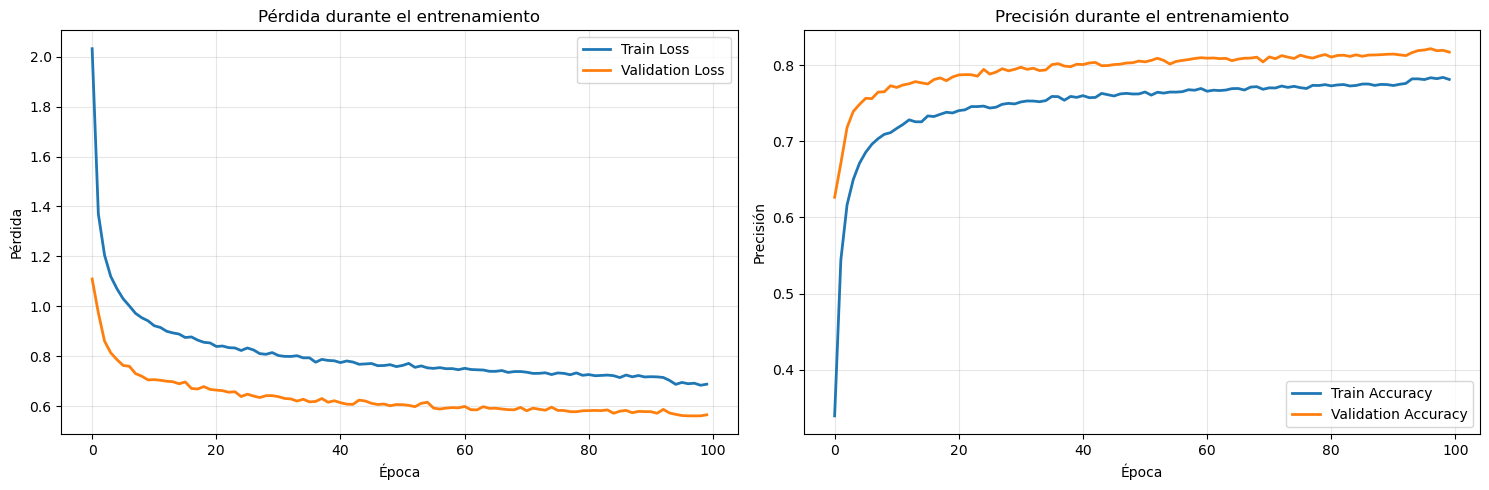


ANÁLISIS DE ERRORES POR ACTIVIDAD
   Actividad  Precisión  Errores  Total
0          A   0.827637      116    673
1          B   0.987860        8    659
2          C   0.738275      173    661
3          D   0.772464      157    690
4          E   0.849854      103    686
5          F   0.947933       34    653
6          G   0.957478       29    682
7          H   0.773196      154    679
8          I   0.627019      254    681
9          J   0.679883      218    681
10         K   0.671512      226    688
11         L   0.208396      528    667
12         M   0.893016       72    673
13         O   0.940729       39    658
14         P   0.948148       35    675
15         Q   0.960352       27    681
16         R   0.979351       14    678
17         S   0.955687       30    677


In [ ]:
# Métricas por clase
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_classes, average=None)

# Crear DataFrame con métricas por clase
metrics_df = pd.DataFrame({
    'Actividad': label_encoder.classes_,
    'Precisión': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Soporte': support
})

print("\n" + "="*60)
print("MÉTRICAS POR CLASE")
print("="*60)
print(metrics_df.round(4))

# Métricas globales adicionales
print(f"\nPrecisión promedio (macro): {precision.mean():.4f}")
print(f"Recall promedio (macro): {recall.mean():.4f}")
print(f"F1-Score promedio (macro): {f1.mean():.4f}")
print(f"Precisión balanceada: {balanced_accuracy_score(y_test, y_pred_classes):.4f}")

# Curvas de entrenamiento
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Pérdida
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Pérdida durante el entrenamiento')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Pérdida')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Precisión
axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_title('Precisión durante el entrenamiento')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Precisión')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis de errores por actividad
error_analysis = []
for i, activity in enumerate(label_encoder.classes_):
    mask = y_test == i
    if mask.sum() > 0:
        activity_accuracy = accuracy_score(y_test[mask], y_pred_classes[mask])
        error_analysis.append({
            'Actividad': activity,
            'Precisión': activity_accuracy,
            'Errores': (y_test[mask] != y_pred_classes[mask]).sum(),
            'Total': mask.sum()
        })

error_df = pd.DataFrame(error_analysis)
print("\n" + "="*50)
print("ANÁLISIS DE ERRORES POR ACTIVIDAD")
print("="*50)
print(error_df)

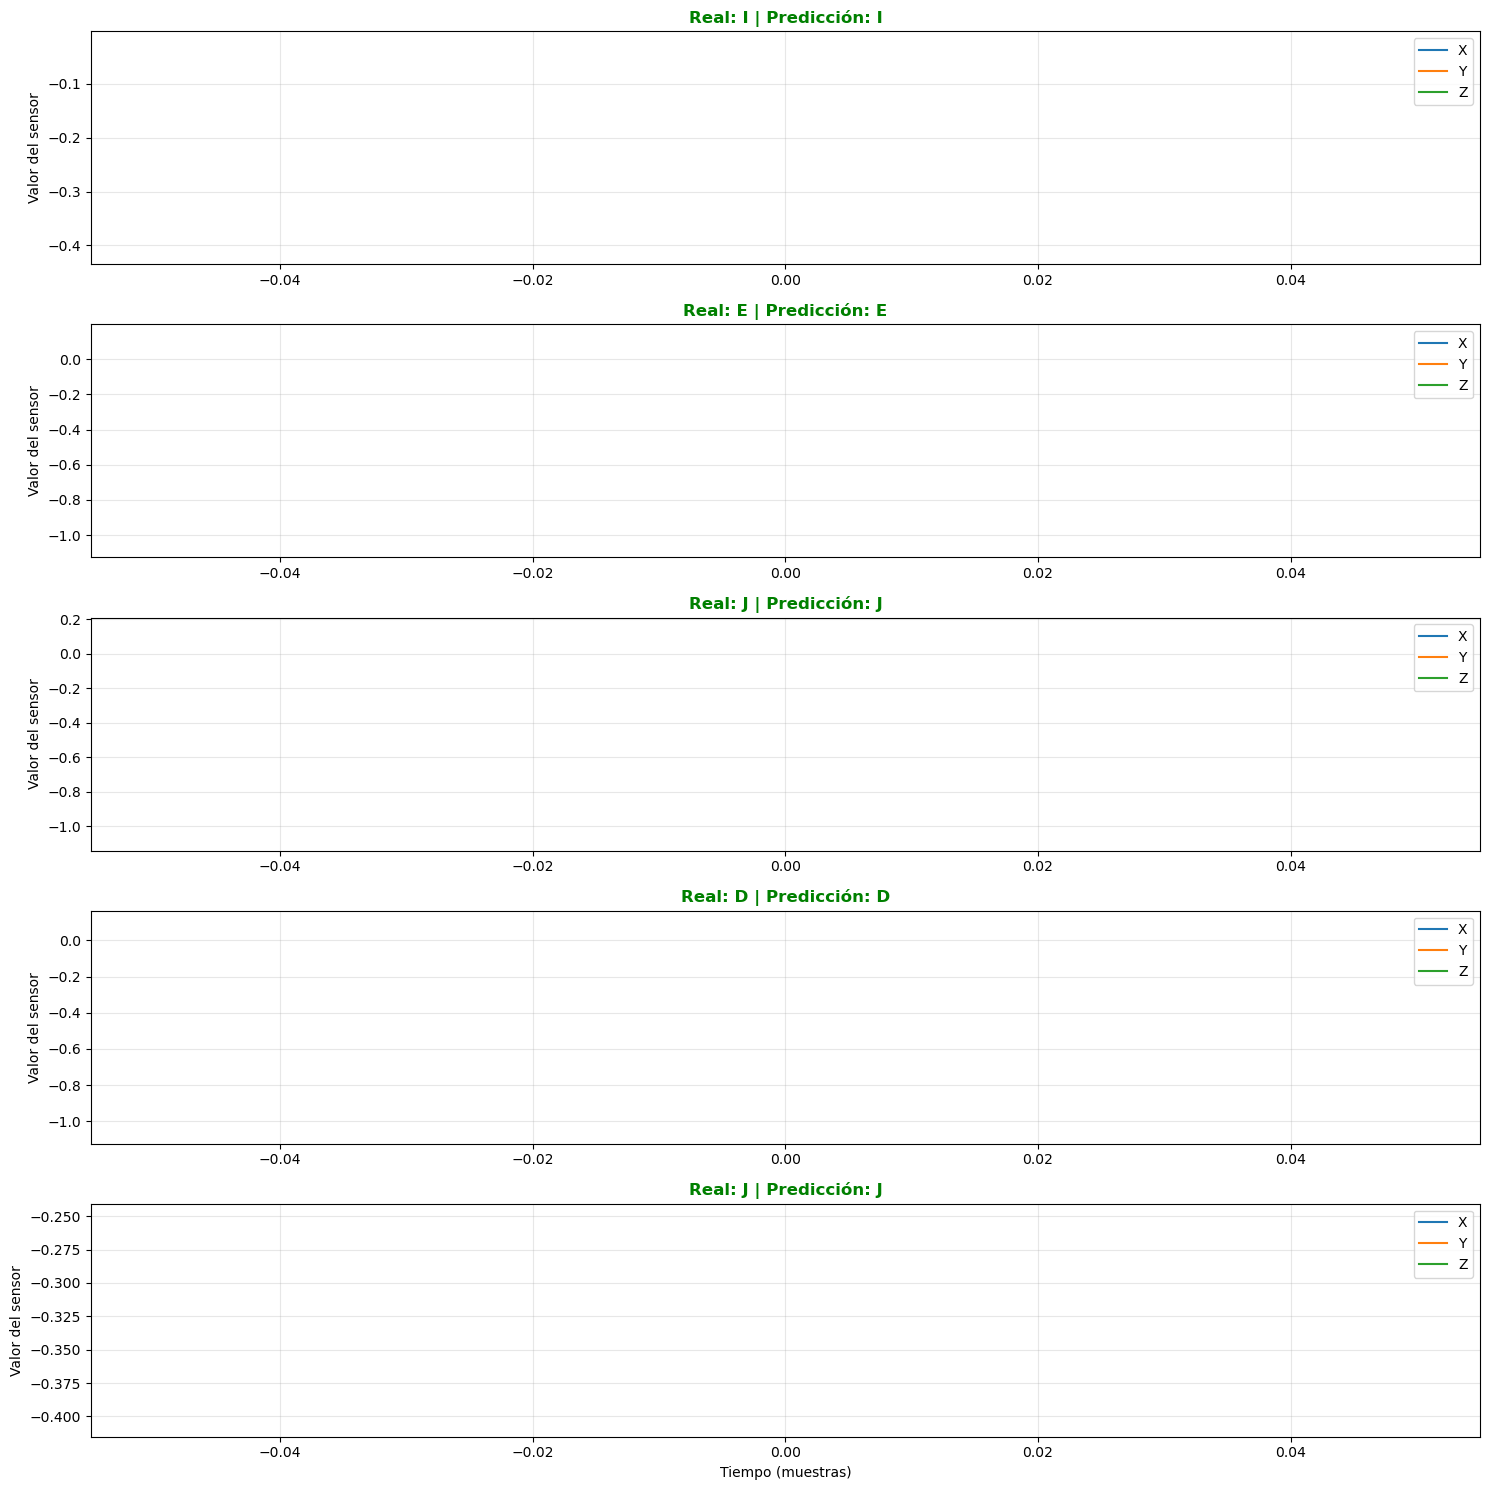


Resumen del modelo:
- Arquitectura: CNN-LSTM
- Ventana temporal: 1 muestras
- Características: 136 ejes (X, Y, Z)
- Clases: 18
- Precisión final: 0.8174
- Muestras de entrenamiento: 36426
- Muestras de test: 12142


In [21]:
def plot_prediction_examples(X_test, y_test, y_pred_classes, label_encoder, n_examples=5):
    """
    Muestra ejemplos de predicciones vs valores reales
    """
    fig, axes = plt.subplots(n_examples, 1, figsize=(15, 3*n_examples))
    
    # Seleccionar ejemplos aleatorios
    indices = np.random.choice(len(X_test), n_examples, replace=False)
    
    for i, idx in enumerate(indices):
        # Datos de la muestra
        sample = X_test[idx]
        true_label = label_encoder.classes_[y_test[idx]]
        pred_label = label_encoder.classes_[y_pred_classes[idx]]
        
        # Graficar las tres dimensiones
        axes[i].plot(sample[:, 0], label='X', linewidth=1.5)
        axes[i].plot(sample[:, 1], label='Y', linewidth=1.5)
        axes[i].plot(sample[:, 2], label='Z', linewidth=1.5)
        
        # Título con predicción
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f'Real: {true_label} | Predicción: {pred_label}', 
                         color=color, fontweight='bold')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        axes[i].set_ylabel('Valor del sensor')
        
        if i == n_examples - 1:
            axes[i].set_xlabel('Tiempo (muestras)')
    
    plt.tight_layout()
    plt.show()

# Mostrar ejemplos de predicciones
plot_prediction_examples(X_test, y_test, y_pred_classes, label_encoder, n_examples=5)

print(f"\nResumen del modelo:")
print(f"- Arquitectura: CNN-LSTM")
print(f"- Ventana temporal: {X_train.shape[1]} muestras")
print(f"- Características: {X_train.shape[2]} ejes (X, Y, Z)")
print(f"- Clases: {num_classes}")
print(f"- Precisión final: {test_accuracy:.4f}")
print(f"- Muestras de entrenamiento: {len(X_train)}")
print(f"- Muestras de test: {len(X_test)}")

Todos los modelos deben de guardarse con el siguiente formato:

**{nombre del modelo}_har_model_{precision}.h5**

Antes de ello, es importante revisar el rendimiento del modelo multiclase, así que no solo nos debemos de basar en la precision (accuracy), sino en el recall para tener en cuenta un posible desbalance entre clases en caso se presente el caso.

In [22]:
# Guardar modelo
model.save('./models/cnn-lstm_har_model_82.h5')
print("Modelo guardado como 'cnn-lstm_har_model_82.h5'")

Modelo guardado como 'cnn-lstm_har_model_82.h5'
